In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

# Merging IMDb and CMU movies datasets 

In [ ]:
## Read the data ##
movie_cols = ['wikiID', 'freebasemovID', 'movie_name', 'release_date', 'boxoffice', 'runtime', 'language', 'country', 'genre']

#folder
data_folder = './data/'
imdb_original = pd.read_csv(data_folder+'imdb_movies.tsv', sep='\t')
imdb_ratings_original= pd.read_csv(data_folder+'ratings.tsv', sep='\t')
cmu_original = pd.read_csv(data_folder+'movie.metadata.tsv', sep='\t', names=movie_cols)


In [ ]:
imdb = imdb_original[['tconst','primaryTitle','startYear']]

imdb = imdb[imdb['startYear']<='2011']

#merge with there ratings
imdb = imdb.merge(imdb_ratings_original,how='inner',on='tconst')

#lower(title)
imdb = imdb[imdb['primaryTitle'].apply(lambda x : type(x))==str]
imdb['primaryTitle'] = imdb['primaryTitle'].apply(lambda x : x.lower())

imdb = imdb.sort_values(by=['primaryTitle','numVotes'],ascending=[True,False])

imdb = imdb.drop_duplicates(subset=['primaryTitle','startYear'])

imdb

In [ ]:
cmu = cmu_original[['wikiID','movie_name']]
cmu['movie_name'] = cmu['movie_name'].apply(lambda x : x.lower())
cmu

In [ ]:
cmu_imdb = cmu.merge(imdb,left_on='movie_name',right_on='primaryTitle')
cmu_imdb_fine = cmu_imdb[~cmu_imdb.duplicated(subset=['wikiID'],keep=False)]
wiki_rate = cmu_imdb_fine[['wikiID','averageRating']]

In [ ]:
cmu_final = cmu_original.merge(wiki_rate,on='wikiID',how='left')
cmu_final

# Cleaning the Dataset from the Merging of IMDb and CMU Datasets

After merging the IMDb and CMU datasets, we have a dataset with ... rows and ... columns. 
We will now investigate each column and clean the data as needed.

In [384]:
cmu_final.head()

,wikiID,freebasemovID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",5.6
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",6.1
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.9


In [385]:
cmu_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wikiID         81741 non-null  int64  
 1   freebasemovID  81741 non-null  object 
 2   movie_name     81741 non-null  object 
 3   release_date   74839 non-null  object 
 4   boxoffice      8401 non-null   float64
 5   runtime        61291 non-null  float64
 6   language       81741 non-null  object 
 7   country        81741 non-null  object 
 8   genre          81741 non-null  object 
 9   averageRating  39979 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 6.2+ MB


In [386]:
cmu_final.sample(5)

,wikiID,freebasemovID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating
73802,6015667,/m/0fkqcp,Sye,2004-09-23,NaN,NaN,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",7.2
15485,1303197,/m/04r9kj,Cinderella,1957-03-31,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/04t36"": ""M...",NaN
9565,3597588,/m/09ny1w,Cement,1999,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",5.7
74014,18353498,/m/04f516w,Antares,2004,NaN,105.0,"{""/m/04306rv"": ""German Language""}","{""/m/0h7x"": ""Austria"", ""/m/0345h"": ""Germany""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/0hj3n16"": ...",6.1
13538,14570884,/m/03d87p3,Fatal Deviation,1998,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland""}","{""/m/02kdv5l"": ""Action""}",4.7


## Let's put data in a more convenient format

### Release Dates

In [387]:
#Change the date format to make it the same in each rows
# Assuming 'release_date' contains different format (based on the samples printed above: only the year or the full date)
def parse_date(date_string):
    try:
        return pd.to_datetime(date_string, format='%Y')
    except ValueError:
        try:
            return pd.to_datetime(date_string, format='%Y-%m-%d')
        except ValueError:
            return pd.NaT

cmu_final['date'] = cmu_final['release_date'].apply(lambda x: parse_date(str(x)))

In [388]:
cmu_final.sample(5)

,wikiID,freebasemovID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,date
71487,6451274,/m/0g5w9_,National Lampoon's Dorm Daze 2,2006-09-05,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gsy3b"": ""Sex comedy"", ""/m/01z4y"": ""Comed...",NaN,2006-09-05
36742,26245382,/m/0b748w8,Vasantha Maligai,1972,NaN,162.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",6.7,1972-01-01
61424,6980481,/m/0gzr0_,Carnosaur 2,1993,NaN,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0cq22z7"": ""Sci-Fi Horror"", ""/m/0qdzd"": ""B...",3.7,1993-01-01
11282,21086727,/m/05c4z00,Stournara 288,NaN,NaN,NaN,{},"{""/m/035qy"": ""Greece""}","{""/m/01z4y"": ""Comedy""}",6.9,NaT
66489,10628870,/m/02qkn9s,Valli,1993,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}",{},3.9,1993-01-01


We can see when only the year was present in the original dataset, the formated date added the first day of the year to make it a valid format. This is not an issue since we will only use the years for our analysis.
We will now drop the original date column, only keep years and rename the new one to release_year.

In [389]:
#Drop release_date column 
cmu_final.drop(columns=['release_date'], inplace=True)

#Only keep year in date column and rename it to release_year
cmu_final['release_year'] = cmu_final['date'].dt.year


In [390]:
#Check if too many NaT values appears (in that case, we will have to either drop the rows or try to fix the date manually)
cmu_final['date'].isna().sum()
print('The percentage of NaT values is: ', cmu_final['date'].isna().sum()/len(cmu_final)*100, '%')

The percentage of NaT values is:  12.474767864352039 %


We will accept this amount of NaT (we still have close to 70k movies with a release year).

We still keep the movies NaT in case other variables are still useful.

In [391]:
#Checking if years are consistent (not a future or too old year)
cmu_final['release_year'].describe()

count    71544.00000
mean      1977.84260
std         28.77973
min       1888.00000
25%       1956.00000
50%       1986.00000
75%       2004.00000
max       2016.00000
Name: release_year, dtype: float64

The min (1888) and max (2016) values are reasonable. we may drop some of the years based on the number of movies that specific year.

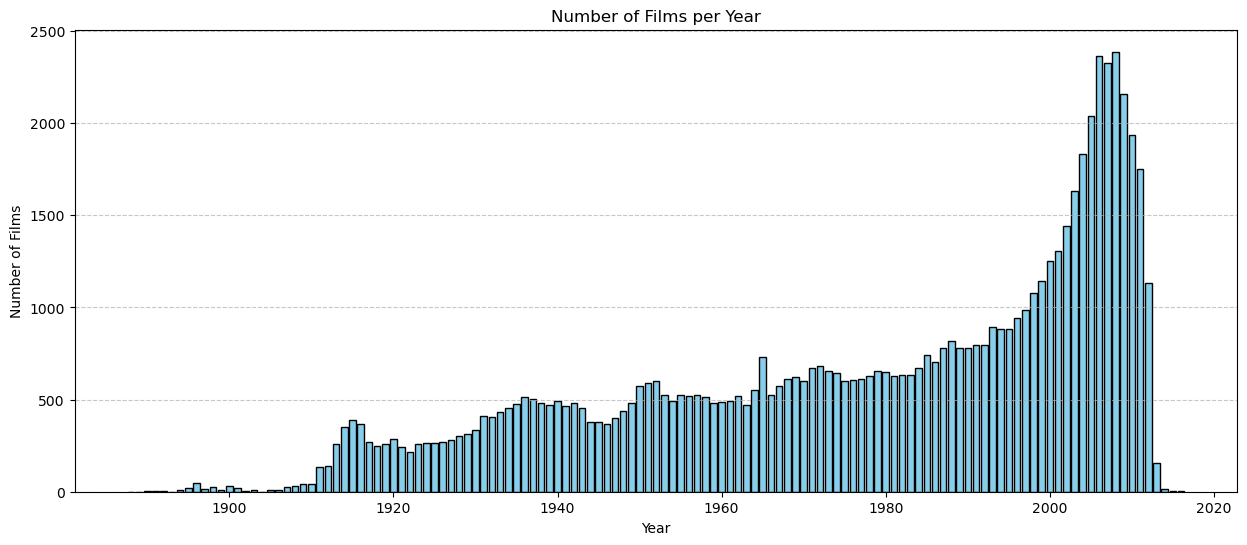

In [392]:
# Plotting the bar plot
grouped_year = cmu_final[['release_year', 'movie_name']].groupby('release_year').count().reset_index()

# Assuming that the relevant columns are 'release_year' and 'movie_name'
grouped_year.columns = ['release_year', 'number_films']

plt.figure(figsize=(15, 6))
plt.bar(grouped_year['release_year'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [393]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_year']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_year']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_year']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the number of films for year 2010
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_year']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year} with {max_films_count} films')


Number of years with less than 100 films: 26
Number of years with less than 500 films: 69
Number of years with less than 1000 films: 114
The year with the max number of films is: 2008.0 with 2388 films


There are not a lot of films with less than 100 movies per year. We will remove these years from the dataset without losing too much information.

In [394]:
#In the original CMU dataset remove the rows with release year with less than 100 films

years_to_remove = years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_year'].tolist()
cmu_final = cmu_final[~cmu_final['release_year'].isin(years_to_remove)]


#test if the rows have been removed
print(f'The minimum number of film in a year is {cmu_final["release_year"].value_counts().min()} in year {cmu_final["release_year"].value_counts().idxmin()}')


The minimum number of film in a year is 135 in year 1911.0


### Dictionnaries

We can notice 3 columns contains dictionnaries: langage, country and genre. We will now extract the information from these columns and create new columns for each of the values.

In [395]:
#check the max number of values in a single dictionnary for each of the three columns

print(f'The max number of values in a single dictionnary for language is {cmu_final["language"].apply(lambda x: len(x)).max()}')
print(f'The max number of values in a single dictionnary for country is {cmu_final["country"].apply(lambda x: len(x)).max()}')
print(f'The max number of values in a single dictionnary for genre is {cmu_final["genre"].apply(lambda x: len(x)).max()}')

#check the min number of values in a single dictionnary for each of the three columns
print(f'The min number of values in a single dictionnary for language is {cmu_final["language"].apply(lambda x: len(x)).min()}')
print(f'The min number of values in a single dictionnary for country is {cmu_final["country"].apply(lambda x: len(x)).min()}')
print(f'The min number of values in a single dictionnary for genre is {cmu_final["genre"].apply(lambda x: len(x)).min()}')

The max number of values in a single dictionnary for language is 494
The max number of values in a single dictionnary for country is 352


The max number of values in a single dictionnary for genre is 461
The min number of values in a single dictionnary for language is 2
The min number of values in a single dictionnary for country is 2
The min number of values in a single dictionnary for genre is 2


In [396]:
#Split the dictionnary values into list:

cmu_final['language'] = cmu_final['language'].apply(lambda x: list(ast.literal_eval(x).values())) #we use ast.literal_eval to convert the string into a dictionnary since if we directly use x.values() it return empty list
cmu_final['country'] = cmu_final['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_final['genre'] = cmu_final['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

#Check the max number of values in each list (i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_final["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_final["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_final["genre"].apply(len).max()}')

The max number of values in a single list for language is 15
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [403]:
np.unique(np.hstack(cmu_final['country'].values))




array(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Burma', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China',
       'Colombia', 'Congo', 'Costa Rica', 'Crime', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Czechoslovakia',
       'Democratic Republic of the Congo', 'Denmark', 'Egypt', 'England',
       'Estonia', 'Ethiopia', 'Federal Republic of Yugoslavia', 'Finland',
       'France', 'Georgia', 'Georgian SSR', 'German Democratic Republic',
       'German Language', 'Germany', 'Greece', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Iraqi Kurdistan', 'Ireland', 'Isle of Man',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya',
       'Kingdom of Great Britain', 'Ki

Clearly we can't split each value in a new column. But we don't need to keep the keys from the dictionnaries so we will keep these lists of values 

## Let's clean the remaining columns and remove/correct the inconsistent rows

### Movie Name and FreebasemovieID

We need to check if there is any ducplicate movie names and if the FreebaseID is unique for each movie.

In [340]:
#Check if there are duplicates in the movie_name and freebasemovID column

print(f'The number of duplicates in the movie_name column is {cmu_final["movie_name"].duplicated().sum()}')
print(f'The number of duplicates in the freebasemovID column is {cmu_final["freebasemovID"].duplicated().sum()}')

The number of duplicates in the movie_name column is 6211
The number of duplicates in the freebasemovID column is 0


It appears we have film with the same name but different FreebaseID. 
Let's print some sample to see what make them different.

In [343]:
#print some duplicates in the movie_name column
cmu_final[cmu_final['movie_name'].duplicated(keep=False)].sort_values(by='movie_name')


,wikiID,freebasemovID,movie_name,boxoffice,runtime,language,country,genre,averageRating,date,release_year
77290,8422241,/m/0272wbj,100 Days,NaN,161.0,[Hindi Language],[India],"[Horror, Suspense, World cinema]",NaN,1991-01-01,1991.0
18992,15498803,/m/03mc7x8,100 Days,NaN,100.0,[English Language],[United Kingdom],[Drama],NaN,2001-02-01,2001.0
12205,31239628,/m/0gj9wpb,100% Love,NaN,140.0,[Telugu language],[],[Romantic comedy],7.0,NaT,NaN
69188,34757217,/m/0j3df_d,100% Love,NaN,NaN,[Bengali Language],[India],"[Romance Film, Comedy film]",7.0,2012-01-20,2012.0
17891,33940717,/m/0j626hk,12,NaN,124.0,[English Language],[United States of America],"[Comedy film, Musical, Indie]",NaN,2003-06-27,2003.0
...,...,...,...,...,...,...,...,...,...,...,...
79,11353896,/m/02r8pmz,Zindagi,NaN,NaN,[Hindi Language],[India],[Bollywood],NaN,1976-01-01,1976.0
40871,11353680,/m/02r8p2s,Zindagi,NaN,NaN,[Hindi Language],[India],"[Family Film, Drama, Musical]",NaN,1964-01-01,1964.0
75600,33215343,/m/0h67l5w,Zindagi,NaN,120.0,[Hindi Language],[India],"[Family Film, Drama]",NaN,1940-01-01,1940.0
3321,7714332,/m/0269q28,Zoetrope,NaN,18.0,[English Language],[United States of America],[Short Film],6.8,1999-01-01,1999.0


The use of same names for different movies seem to have different reasons:
- The same movie name is used for different movies (e.g. "100 Days", produced in India in 1991 and in UK in 2001, with different genres and runtime)
- The same movie name is used for different versions of the same movie (e.g. "100% Love", produced in Telugu in Bengali but with similar properties: just a different language)

### Run Time

In [344]:
cmu_final['runtime'].describe()

count    6.108700e+04
mean     1.121635e+02
std      4.367340e+03
min      5.000000e-02
25%      8.100000e+01
50%      9.300000e+01
75%      1.070000e+02
max      1.079281e+06
Name: runtime, dtype: float64

Min and max run times can't be true. A few seconds and a couples of years are not possible. We will plot the distribution of run times to see if we can find any other outliers.

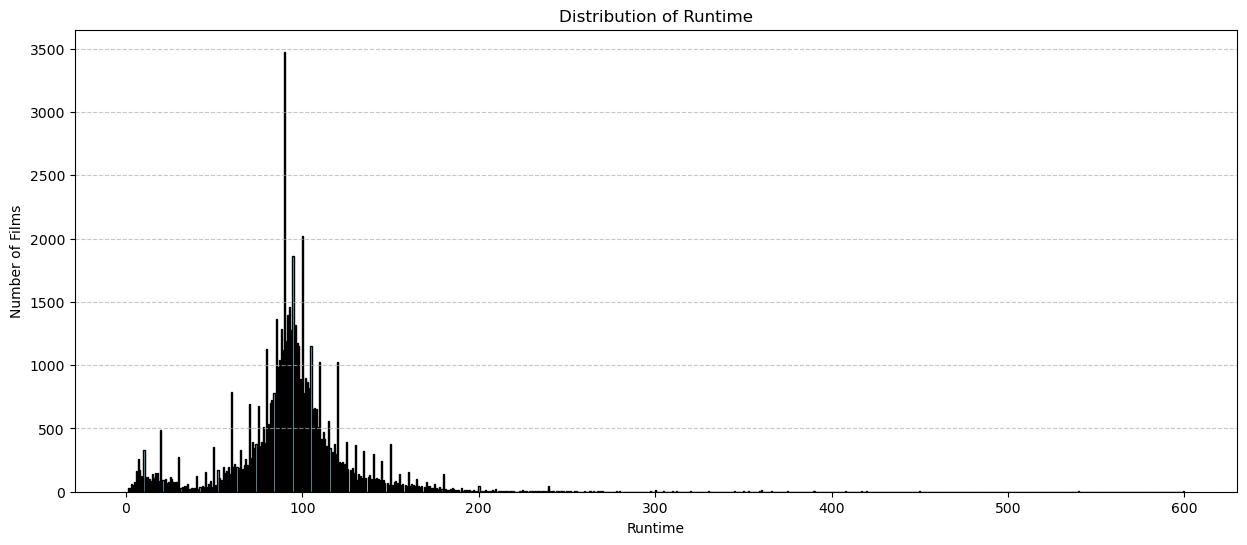

The proportion of films with runtime more than 180 minutes is 0.960639606396064%
The proportion of films with runtime less than 10 minutes is 1.2632226322263223%


In [361]:
#Drop the outliers in runtime column
cmu_final = cmu_final.drop(cmu_final[cmu_final['runtime'] > 600].index) #remove movies longer than 600 minutes (10hrs)
cmu_final = cmu_final.drop(cmu_final[cmu_final['runtime'] < 1].index) #remove movies shorter than 1 minute

#Plot the distribution of the runtime
plt.figure(figsize=(15, 6))
plt.hist(cmu_final['runtime'], bins=1000, color='skyblue', edgecolor='black')
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'The proportion of films with runtime more than 180 minutes is {len(cmu_final[cmu_final["runtime"] > 180])/len(cmu_final)*100}%')
print(f'The proportion of films with runtime less than 10 minutes is {len(cmu_final[cmu_final["runtime"] < 10])/len(cmu_final)*100}%')


Now the distribution is way better. We will keep the movies with a run time between 10 and 180 minutes.

In [362]:
#Only keep the movies with runtime between 10 and 180 minutes
cmu_final = cmu_final[cmu_final['runtime'] <= 180]
cmu_final = cmu_final[cmu_final['runtime'] >= 10]

### Box Office and Ratings

We plan to rely a lot on box office. Let's then first check the percentage of missing boxoffice to see if it makes sense to use such metric.

In [364]:
print(f'The percentage of missing values in Box Office column is {cmu_final["boxoffice"].isna().sum()/len(cmu_final)*100}%')
print(f'The percentage of missing values in Ratings column is {cmu_final["averageRating"].isna().sum()/len(cmu_final)*100}%')

The percentage of missing values in Box Office column is 86.09877585479106%
The percentage of missing values in Ratings column is 49.11777121148164%


Thankfully we merge the datasets. Ratings will enable a more consistent and reliable analysis.

Let's check if we can remove Box Office NaN values because there are for old movies

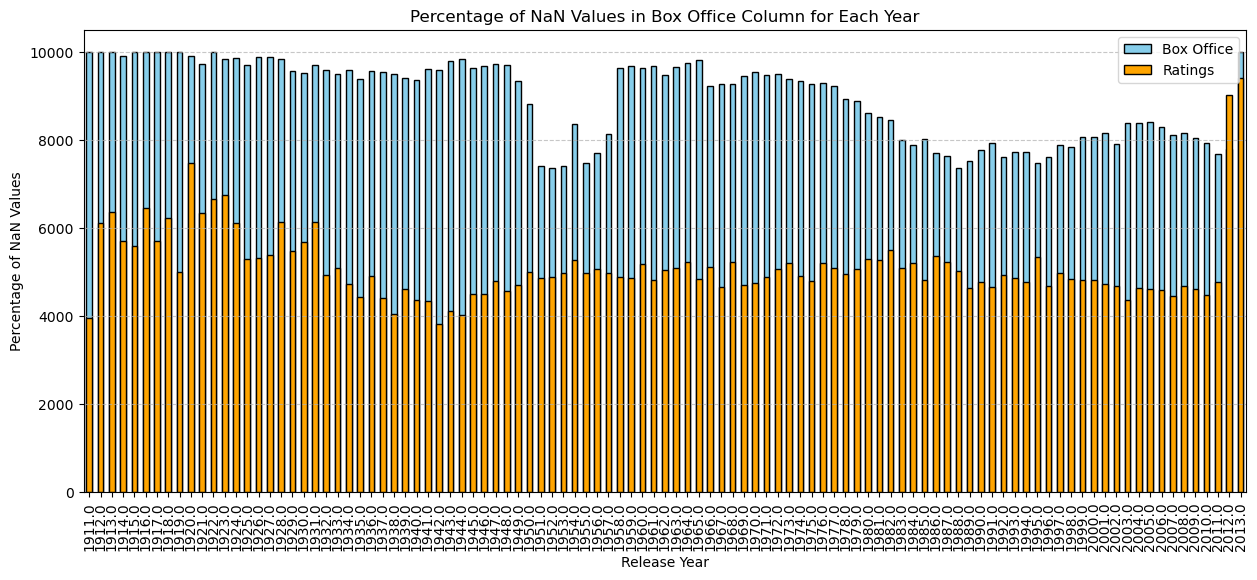

In [377]:
#Plot the percentage of NaN values in the boxoffice column for each year
import matplotlib.pyplot as plt

# Calculate the percentage of NaN values for each year
bo_nan_percentage_by_year = cmu_final.groupby('release_year')['boxoffice'].apply(lambda x: (x.isna().mean() * 100) * 100)
rat_nan_percentage_by_year = cmu_final.groupby('release_year')['averageRating'].apply(lambda x: (x.isna().mean() * 100) * 100)

# Plot the percentage of NaN values for each year
plt.figure(figsize=(15, 6))
bo_nan_percentage_by_year.plot(kind='bar', color='skyblue', edgecolor='black')
rat_nan_percentage_by_year.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Percentage of NaN Values in Box Office Column for Each Year')
plt.xlabel('Release Year')
plt.ylabel('Percentage of NaN Values')
plt.legend(['Box Office', 'Ratings'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Each Year Ratings are less likely to be NaN. We will more likely use these values for now.

# Cleaning the Character dataset